In [1]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
def ddim_sample(xt, model, noise_schedule, ddim_steps, steps_to_show):
    T = noise_schedule["T"]
    ddim_steps = torch.linspace(0, T - 1, num_steps, device=device, dtype=torch.long)
    timesteps = list(reversed(ddim_steps.tolist()))  # e.g. [392, 384, ..., 0]

    # find the next closest timestep in steps_to_show
    # For each step in steps_to_show, find the closest timestep in ddim_steps
    steps_to_show = [
        int(min(ddim_steps, key=lambda t: abs(t - x)).item()) for x in steps_to_show
    ]
    print(f"Updated steps_to_show: {steps_to_show}")

    snapshots = {}

    alpha_cumprod = noise_schedule["alphas_bar"]
    sqrt_alphas_bar = noise_schedule["sqrt_alphas_bar"]
    sqrt_one_minus_alphas_bar = noise_schedule["sqrt_one_minus_alphas_bar"]

    model.eval()
    with torch.no_grad():
        for i, t in enumerate(timesteps):
            t_int = int(t)
            t_long = torch.full((1,), t_int, device=device, dtype=torch.long)
            t_float = t_long.float() / (T - 1)

            # predict eps at this timestep
            eps = model(xt, t_float)

            sqrt_alpha_bar_t = sqrt_alphas_bar[t_int].view(-1, 1, 1, 1)
            sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alphas_bar[t_int].view(
                -1, 1, 1, 1
            )

            # estimate x0
            x0_hat = (xt - sqrt_one_minus_alpha_bar_t * eps) / sqrt_alpha_bar_t
            x0_hat = x0_hat.clamp(-1, 1)

            # if this is the last step (t == 0 in our schedule), we just take x0_hat
            if i == len(timesteps) - 1:
                xt = x0_hat
            else:
                # DDIM deterministic update to the *next* timestep in our chosen schedule
                t_next = int(timesteps[i + 1])
                alpha_bar_next = alpha_cumprod[t_next]
                sqrt_alpha_bar_next = torch.sqrt(alpha_bar_next).view(1, 1, 1, 1)
                sqrt_one_minus_alpha_bar_next = torch.sqrt(1 - alpha_bar_next).view(
                    1, 1, 1, 1
                )

                # η = 0 DDIM (no extra noise term)
                xt = sqrt_alpha_bar_next * x0_hat + sqrt_one_minus_alpha_bar_next * eps

            if t_int in steps_to_show:
                img = xt.clamp(-1, 1)
                img = (img + 1) / 2
                snapshots[t_int] = img.cpu().squeeze().permute(1, 2, 0)

    return snapshots

In [ ]:
# load model
from dit import DiT

model = DiT().to(device)
model.load_state_dict(torch.load("checkpoints/model_2000.pth"))

<All keys matched successfully>

Updated steps_to_show: [298, 201, 100, 0]


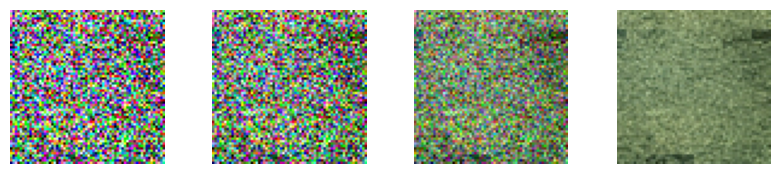

In [15]:
from diffusion import get_noise_schedule, T

noise_schedule = get_noise_schedule(T, device)

num_steps = 100
steps_to_show = [300, 200, 100, 0]

# [B, C, H, W]
xt = torch.randn(1, 3, 64, 64).to(device)

ddim_snapshots = ddim_sample(xt, model, noise_schedule, num_steps, steps_to_show)
fig, axs = plt.subplots(1, len(ddim_snapshots), figsize=(10, 2))
for i, snapshot in enumerate(ddim_snapshots.values()):
    axs[i].imshow(snapshot)
    axs[i].axis("off")
plt.show()

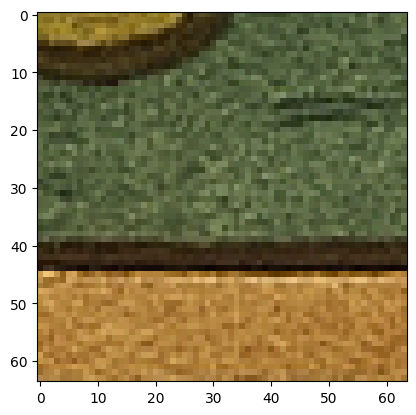

In [5]:
from dataset import WorldDataset
from torch.utils.data import DataLoader

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

dataset = WorldDataset("data/world_map.png")
dataset = torch.utils.data.Subset(dataset, range(1))

img = dataset[0][0]
plt.imshow(img.permute(1, 2, 0))
plt.show()

x0 shape: torch.Size([1, 3, 64, 64]), xt shape: torch.Size([1, 3, 64, 64]), x0_hat shape: torch.Size([1, 3, 64, 64])


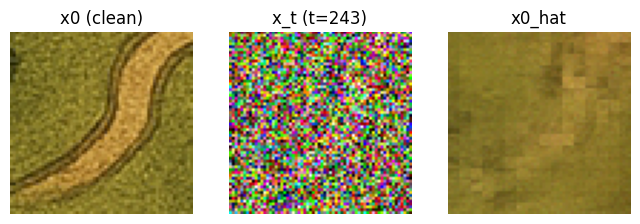

In [6]:
model.eval()
with torch.no_grad():
    imgs, _, _ = dataset[0]
    x0 = (imgs.to(device) / 127.5) - 1
    x0 = x0.unsqueeze(0)

    B = x0.shape[0]
    t = torch.randint(0, T, (B,), device=device)

    noise_schedule = get_noise_schedule(T, device)

    sqrt_alpha_cumprod = noise_schedule["sqrt_alphas_bar"]
    sqrt_one_minus_alpha_cumprod = noise_schedule["sqrt_one_minus_alphas_bar"]

    # re-use your q_sample from training
    def q_sample(x0, t):
        eps = torch.randn_like(x0)
        sqrt_alpha_bar_t = sqrt_alpha_cumprod[t].view(B, 1, 1, 1)
        sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_cumprod[t].view(B, 1, 1, 1)
        xt = x0 * sqrt_alpha_bar_t + eps * sqrt_one_minus_alpha_bar_t
        return xt, eps

    xt, eps = q_sample(x0, t)
    t_float = t.float() / (T - 1)

    eps_pred = model(xt, t_float)
    x0_hat = (
        xt - sqrt_one_minus_alpha_cumprod[t].view(B, 1, 1, 1) * eps_pred
    ) / sqrt_alpha_cumprod[t].view(B, 1, 1, 1)

    # unnormalize for visualization
    def to_img(x):
        x = x.clamp(-1, 1)
        x = (x + 1) / 2
        return x.cpu()

    print(f"x0 shape: {x0.shape}, xt shape: {xt.shape}, x0_hat shape: {x0_hat.shape}")
    i = 0
    fig, axs = plt.subplots(1, 3, figsize=(8, 3))
    axs[0].imshow(to_img(x0[i]).permute(1, 2, 0))
    axs[0].set_title("x0 (clean)")
    axs[1].imshow(to_img(xt[i]).permute(1, 2, 0))
    axs[1].set_title(f"x_t (t={t[i].item()})")
    axs[2].imshow(to_img(x0_hat[i]).permute(1, 2, 0))
    axs[2].set_title("x0_hat")
    for ax in axs:
        ax.axis("off")
    plt.show()